In [1]:
!ls -la /root/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Feb 21 08:33 .
drwx------ 1 root root 4096 Feb 21 08:35 ..
-rw------- 1 root root   82 Feb 21 08:33 kaggle.json


In [3]:
from pathlib import Path
import os
import getpass
import shutil
import subprocess

REPO_DIR = Path('/content/AnomalyDetection')
REPO_URL = os.environ.get('ANOMALY_REPO_URL', 'https://github.com/kh87joo2/AnomalyDetection.git')
FORCE_RECLONE = os.environ.get('ANOMALY_FORCE_RECLONE', '0') == '1'


def is_repo_root(path: Path) -> bool:
    required = [
        path / 'requirements.txt',
        path / 'configs',
        path / 'trainers',
        path / 'configs' / 'patchtst_ssl.yaml',
        path / 'configs' / 'swinmae_ssl.yaml',
    ]
    return all(p.exists() for p in required)


def clone_repo(repo_url: str, token: str = '') -> subprocess.CompletedProcess:
    clone_url = repo_url
    if token and repo_url.startswith('https://'):
        clone_url = repo_url.replace('https://', f'https://{token}@', 1)
    return subprocess.run(['git', 'clone', clone_url, str(REPO_DIR)], text=True, capture_output=True)


if is_repo_root(REPO_DIR):
    print(f'[info] using existing repo: {REPO_DIR}')
elif REPO_DIR.exists():
    if FORCE_RECLONE:
        print(f'[warn] removing existing directory because ANOMALY_FORCE_RECLONE=1: {REPO_DIR}')
        shutil.rmtree(REPO_DIR)
    else:
        raise RuntimeError(
            f'{REPO_DIR} exists but is not a valid repo root.\n'
            'Set ANOMALY_FORCE_RECLONE=1 to allow removal and reclone, or fix the directory manually.'
        )

if not is_repo_root(REPO_DIR):
    print(f'[info] cloning repo: {REPO_URL}')
    token = os.environ.get('ANOMALY_GH_TOKEN', '').strip()
    result = clone_repo(REPO_URL, token=token)

    if result.returncode != 0 and not token:
        print('[warn] public clone failed. If repo is private, enter a GitHub PAT.')
        token = getpass.getpass('GitHub PAT (private repo only): ').strip()
        if token:
            result = clone_repo(REPO_URL, token=token)

    if result.returncode != 0:
        if result.stderr:
            print('[git]', result.stderr.strip().splitlines()[-1])
        raise RuntimeError('git clone failed. Check repo URL, network, and token permissions.')

if not is_repo_root(REPO_DIR):
    raise FileNotFoundError('Repo root validation failed after clone.')

os.chdir(REPO_DIR)
print('cwd:', Path.cwd())
print('requirements.txt exists:', Path('requirements.txt').exists())
print('configs exists:', Path('configs').exists())
print('trainers exists:', Path('trainers').exists())


[info] using existing repo: /content/AnomalyDetection
cwd: /content/AnomalyDetection
requirements.txt exists: True
configs exists: True
trainers exists: True


In [4]:
# KAGGLE_DATA_DOWNLOAD_SWINMAE
from pathlib import Path
import json
import os
import re
import subprocess
import sys
import zipfile

import numpy as np
import pandas as pd
import yaml

REPO_DIR = Path('/content/AnomalyDetection')
RAW_DIR = REPO_DIR / 'data' / 'raw' / 'vibration'
OUT_DIR = REPO_DIR / 'data' / 'vib'
DATASET = 'mohdsufianbinothman/triaxial-bearing-dataset'

RAW_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)


def run(cmd):
    cmd = [str(x) for x in cmd]
    print('$', ' '.join(cmd))
    subprocess.run(cmd, check=True)


run([sys.executable, '-m', 'pip', 'install', '-q', 'kaggle', 'pandas', 'numpy', 'pyyaml'])

kaggle_dir = Path('/root/.kaggle')
kaggle_dir.mkdir(parents=True, exist_ok=True)
kaggle_json = kaggle_dir / 'kaggle.json'

if not kaggle_json.exists():
    user = os.environ.get('KAGGLE_USERNAME', '').strip()
    key = os.environ.get('KAGGLE_KEY', '').strip()
    if user and key:
        kaggle_json.write_text(json.dumps({'username': user, 'key': key}), encoding='utf-8')
    else:
        from google.colab import files

        print('Upload kaggle.json from https://www.kaggle.com/settings/account')
        uploaded = files.upload()
        if 'kaggle.json' not in uploaded:
            raise FileNotFoundError('kaggle.json not uploaded')
        with kaggle_json.open('wb') as f:
            f.write(uploaded['kaggle.json'])

os.chmod(kaggle_json, 0o600)

run(['kaggle', 'datasets', 'download', '-d', DATASET, '-p', str(RAW_DIR), '--force'])

for zip_path in sorted(RAW_DIR.glob('*.zip')):
    print('[extract]', zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(RAW_DIR)

csv_files = sorted(RAW_DIR.rglob('*.csv'))
npy_files = sorted(RAW_DIR.rglob('*.npy'))
print('csv_found:', len(csv_files), 'npy_found:', len(npy_files))

for p in csv_files[:20]:
    print('-', p)
for p in npy_files[:20]:
    print('-', p)


def norm(name: str) -> str:
    return re.sub(r'[^a-z0-9]+', '_', name.strip().lower()).strip('_')


def detect_axis_map(columns):
    normalized = {norm(c): c for c in columns}
    direct = {'x': None, 'y': None, 'z': None}

    for axis in ['x', 'y', 'z']:
        if axis in normalized:
            direct[axis] = normalized[axis]

    if all(direct.values()):
        return direct

    patterns = {
        'x': ['x', 'acc_x', 'axis_x', 'x_axis', 'ax', 'vib_x'],
        'y': ['y', 'acc_y', 'axis_y', 'y_axis', 'ay', 'vib_y'],
        'z': ['z', 'acc_z', 'axis_z', 'z_axis', 'az', 'vib_z'],
    }
    out = {'x': None, 'y': None, 'z': None}
    for axis, keys in patterns.items():
        for k in keys:
            if k in normalized:
                out[axis] = normalized[k]
                break
    if all(out.values()):
        return out
    return None


prepared = None
for path in csv_files:
    try:
        head = pd.read_csv(path, nrows=5)
    except Exception:
        continue
    axis_map = detect_axis_map(list(head.columns))
    if axis_map is None:
        continue

    df = pd.read_csv(path)
    x_col = axis_map['x']
    y_col = axis_map['y']
    z_col = axis_map['z']

    out = pd.DataFrame()

    col_map = {str(c).strip().lower(): c for c in df.columns}
    ts_col = None
    for key in ['timestamp', 'time', 'datetime', 'date']:
        if key in col_map:
            ts_col = col_map[key]
            break

    if ts_col is None:
        out['timestamp'] = range(len(df))
    else:
        out['timestamp'] = df[ts_col]

    out['x'] = pd.to_numeric(df[x_col], errors='coerce')
    out['y'] = pd.to_numeric(df[y_col], errors='coerce')
    out['z'] = pd.to_numeric(df[z_col], errors='coerce')

    out_csv = OUT_DIR / 'bearing_xyz.csv'
    out.to_csv(out_csv, index=False)
    prepared = out_csv
    print('prepared_csv:', out_csv, 'shape:', out.shape)
    break

if prepared is None:
    # Fallback: first npy with shape (T,3)
    for path in npy_files:
        arr = np.load(path)
        if arr.ndim == 2 and arr.shape[1] == 3:
            out_npy = OUT_DIR / 'bearing_xyz.npy'
            np.save(out_npy, arr.astype(np.float32))
            prepared = out_npy
            print('prepared_npy:', out_npy, 'shape:', arr.shape)
            break

if prepared is None:
    raise RuntimeError('Could not build standardized vibration input (x,y,z). Check dataset file schema.')

base_cfg = REPO_DIR / 'configs' / 'swinmae_ssl.yaml'
real_cfg = REPO_DIR / 'configs' / 'swinmae_ssl_real.yaml'
cfg = yaml.safe_load(base_cfg.read_text(encoding='utf-8'))

if str(prepared).endswith('.npy'):
    cfg['data']['source'] = 'npy'
    cfg['data']['path'] = '/content/AnomalyDetection/data/vib/*.npy'
else:
    cfg['data']['source'] = 'csv'
    cfg['data']['path'] = '/content/AnomalyDetection/data/vib/*.csv'

cfg['data']['timestamp_col'] = 'timestamp'
real_cfg.write_text(yaml.safe_dump(cfg, sort_keys=False), encoding='utf-8')

print('real_config_written:', real_cfg)
print('important: set data.fs in configs/swinmae_ssl_real.yaml to real sampling rate')
print('now run the training cell below; it uses *_real.yaml if present')


$ /usr/bin/python3 -m pip install -q kaggle pandas numpy pyyaml
$ kaggle datasets download -d mohdsufianbinothman/triaxial-bearing-dataset -p /content/AnomalyDetection/data/raw/vibration --force
[extract] /content/AnomalyDetection/data/raw/vibration/triaxial-bearing-dataset.zip
csv_found: 38 npy_found: 0
- /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-100watt-67V2Iv.csv
- /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-200watt-jolm8U.csv
- /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-300watt-Zo8w7U.csv
- /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7outer-100watt-lB5LIS.csv
- /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7outer-200watt-0Pp0qm.csv
- /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7outer-300watt-PzsIeS.csv
- /content/AnomalyDetection/data/raw/vib

In [5]:
# DATA_CHECK_SWINMAE
from pathlib import Path
import numpy as np
import pandas as pd

vib_dir = Path('/content/AnomalyDetection/data/vib')
csv_files = sorted(vib_dir.glob('*.csv'))
npy_files = sorted(vib_dir.glob('*.npy'))

print('vib_dir:', vib_dir)
print('csv_count:', len(csv_files))
print('npy_count:', len(npy_files))

if not csv_files and not npy_files:
    raise FileNotFoundError(f'No CSV/NPY files found in {vib_dir}. Run the Kaggle download cell first.')

if csv_files:
    sample = csv_files[0]
    print('sample_csv:', sample)
    df = pd.read_csv(sample)
    print('shape:', df.shape)
    print('columns:', df.columns.tolist())
    print(df.head(3))

    req = {'x', 'y', 'z'}
    miss = [c for c in req if c not in df.columns]
    if miss:
        print('[warn] missing required axis columns:', miss)
    else:
        print('[ok] x,y,z columns exist')

    if 'timestamp' in df.columns:
        ts_dt = pd.to_datetime(df['timestamp'], errors='coerce')
        dt_sec = ts_dt.diff().dt.total_seconds().dropna()
        dt_sec = dt_sec[dt_sec > 0]

        if len(dt_sec) > 0:
            fs_est = 1.0 / float(dt_sec.median())
            print('estimated_fs_from_datetime_median_dt:', fs_est)
        else:
            ts_num = pd.to_numeric(df['timestamp'], errors='coerce')
            dt_num = ts_num.diff().dropna()
            dt_num = dt_num[dt_num > 0]
            if len(dt_num) > 0:
                fs_est = 1.0 / float(dt_num.median())
                print('estimated_fs_from_numeric_timestamp:', fs_est)
            else:
                print('[warn] could not estimate fs from timestamp')

if npy_files:
    sample_npy = npy_files[0]
    arr = np.load(sample_npy)
    print('sample_npy:', sample_npy)
    print('npy_shape:', arr.shape)
    if arr.ndim == 2 and arr.shape[1] == 3:
        print('[ok] npy shape is (T, 3)')
    else:
        print('[warn] expected npy shape (T, 3)')

print('next: set data.fs in configs/swinmae_ssl_real.yaml to the real sampling rate')


vib_dir: /content/AnomalyDetection/data/vib
csv_count: 1
npy_count: 0
sample_csv: /content/AnomalyDetection/data/vib/bearing_xyz.csv
shape: (143348, 4)
columns: ['timestamp', 'x', 'y', 'z']
   timestamp       x      y       z
0          0  0.2274  2.048  0.8902
1          1  0.5596  2.048  1.0181
2          2  1.1617  2.048  1.0299
[ok] x,y,z columns exist
estimated_fs_from_datetime_median_dt: 999999999.9999999
next: set data.fs in configs/swinmae_ssl_real.yaml to the real sampling rate


In [6]:
# 1. 헤드/컬럼/shape 확인

import pandas as pd
import numpy as np
from pathlib import Path

vib_dir = Path("/content/AnomalyDetection/data/vib")
csvs = sorted(vib_dir.glob("*.csv"))
npys = sorted(vib_dir.glob("*.npy"))

print("csv files:", csvs)
print("npy files:", npys)

if csvs:
    df = pd.read_csv(csvs[0])
    print("selected csv:", csvs[0])
    print("shape:", df.shape)
    print("columns:", df.columns.tolist())
    print(df.head(10))
elif npys:
    arr = np.load(npys[0])
    print("selected npy:", npys[0])
    print("shape:", arr.shape)
    print("first 10 rows:")
    print(arr[:10])
else:
    print("No vib data found.")

csv files: [PosixPath('/content/AnomalyDetection/data/vib/bearing_xyz.csv')]
npy files: []
selected csv: /content/AnomalyDetection/data/vib/bearing_xyz.csv
shape: (143348, 4)
columns: ['timestamp', 'x', 'y', 'z']
   timestamp       x       y       z
0          0  0.2274  2.0480  0.8902
1          1  0.5596  2.0480  1.0181
2          2  1.1617  2.0480  1.0299
3          3  1.0181  2.0480  0.6432
4          4  0.2385  2.0480  0.9981
5          5 -0.5286  2.0480  1.0422
6          6  0.0053  2.0480  1.0871
7          7  0.1773  1.8597  1.1042
8          8  0.5845  1.0774  1.3576
9          9  0.4893  0.7712  0.5467


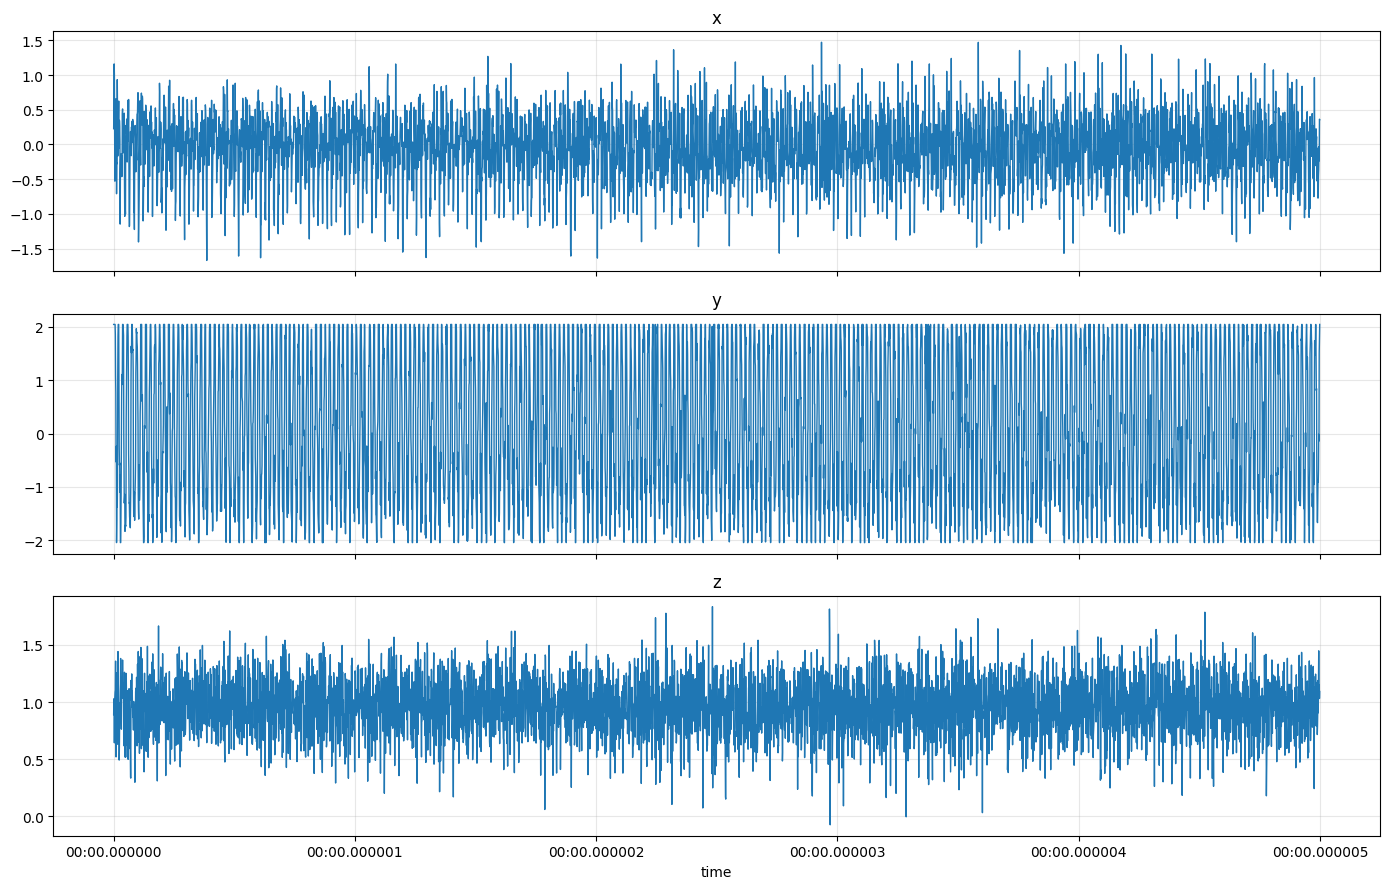

In [7]:
# 2. 시계열 그래프(센서 5개 요청 대응: 진동은 축이 3개라 3개만 가능)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

vib_dir = Path("/content/AnomalyDetection/data/vib")
csvs = sorted(vib_dir.glob("*.csv"))
npys = sorted(vib_dir.glob("*.npy"))

if csvs:
    df = pd.read_csv(csvs[0]).copy()
    # x,y,z 컬럼 확인
    for c in ["x", "y", "z"]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    # 부담 줄이기 위해 앞 5000개만
    df = df.iloc[:5000].copy()

    # timestamp 있으면 시간축으로 사용
    if "timestamp" in df.columns:
        x_axis = pd.to_datetime(df["timestamp"], errors="coerce")
        if x_axis.isna().all():
            x_axis = df.index
    else:
        x_axis = df.index

    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    for i, c in enumerate(["x", "y", "z"]):
        axes[i].plot(x_axis, pd.to_numeric(df[c], errors="coerce"), linewidth=1)
        axes[i].set_title(c)
        axes[i].grid(alpha=0.3)

    axes[-1].set_xlabel("time")
    plt.tight_layout()
    plt.show()

elif npys:
    arr = np.load(npys[0])
    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError(f"Expected (T,3), got {arr.shape}")

    arr = arr[:5000]
    x_axis = np.arange(len(arr))

    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    for i, c in enumerate(["x", "y", "z"]):
        axes[i].plot(x_axis, arr[:, i], linewidth=1)
        axes[i].set_title(c)
        axes[i].grid(alpha=0.3)

    axes[-1].set_xlabel("index")
    plt.tight_layout()
    plt.show()

else:
    print("No vib data found.")

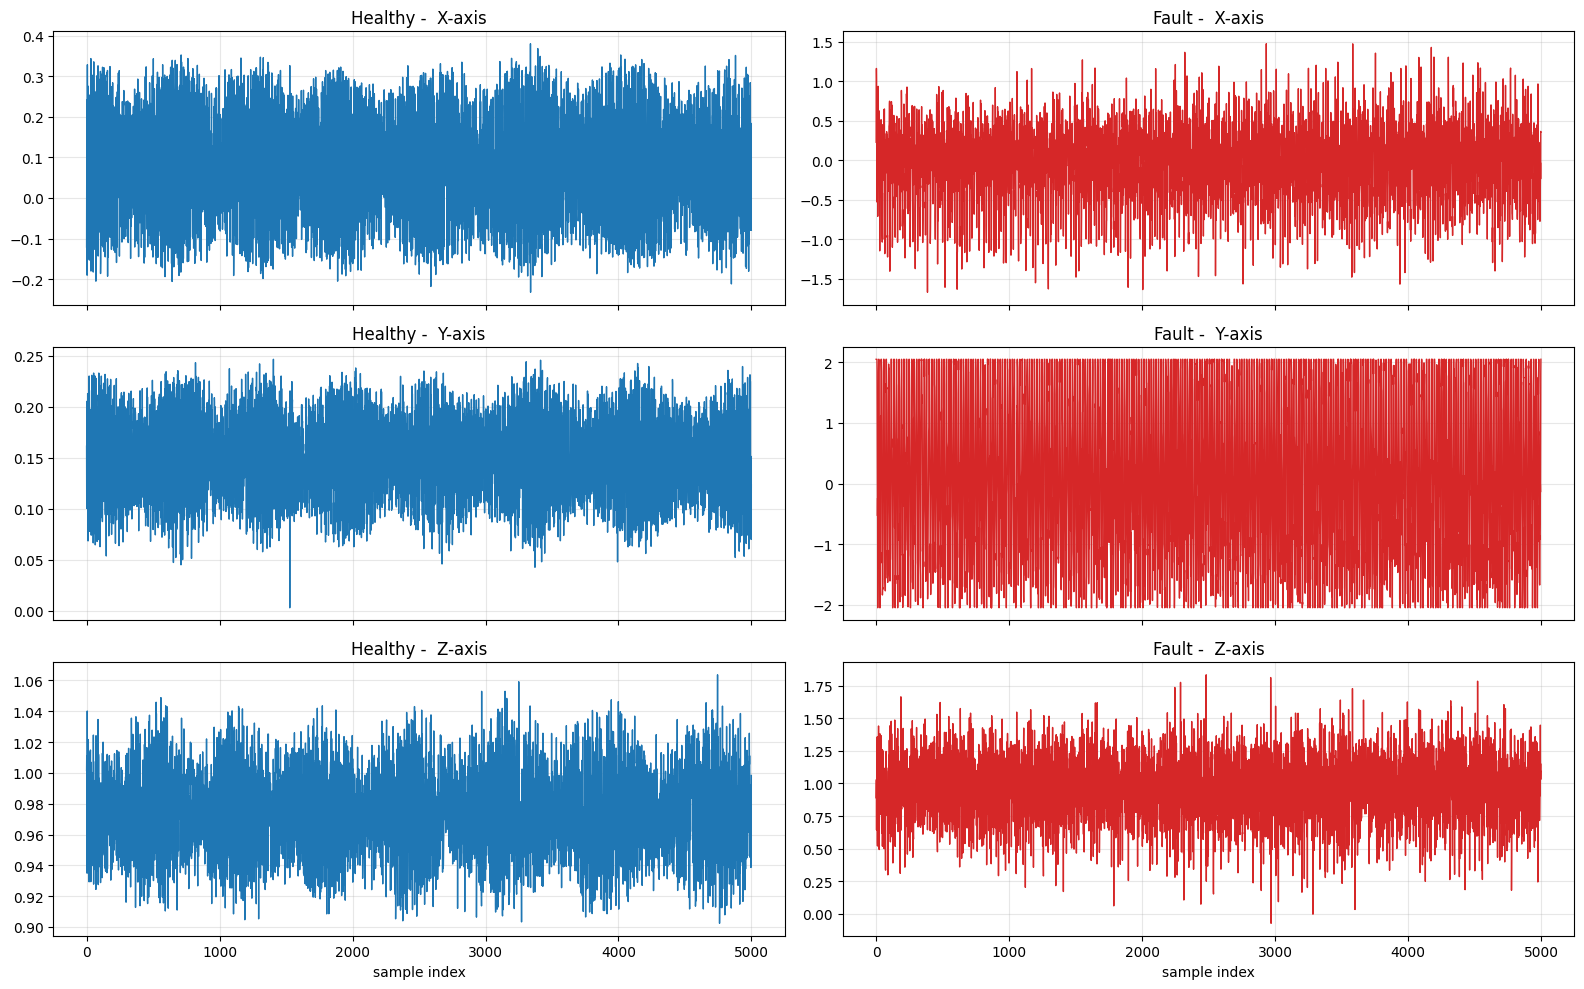

healthy_file: /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/Healthy bearing data/healthy without pulley.csv
fault_file: /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-100watt-67V2Iv.csv
healthy axis cols: (' X-axis', ' Y-axis', ' Z-axis')
fault axis cols: (' X-axis', ' Y-axis', ' Z-axis')


In [6]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# 원본 루트
root = Path("/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2")

# 정상/이상 파일 1개씩 선택
healthy_file = root / "Healthy bearing data" / "healthy without pulley.csv"
fault_file = root / "0.7mm-bearing-faults" / "0.7inner-100watt-67V2Iv.csv"

# CSV 로드
h_df = pd.read_csv(healthy_file)
f_df = pd.read_csv(fault_file)

# 축 컬럼 자동 매핑 (x-axis, x axis, x 등 대응)
def pick_axis_cols(df: pd.DataFrame):
    norm = {c.strip().lower().replace(" ", "").replace("-", ""): c for c in df.columns}

    def find_axis(axis: str):
        cands = [axis, f"{axis}axis", f"{axis}_axis", f"{axis}axis"]
        for k in cands:
            k2 = k.replace("_", "")
            if k2 in norm:
                return norm[k2]
        return None

    x_col = find_axis("x")
    y_col = find_axis("y")
    z_col = find_axis("z")

    if not all([x_col, y_col, z_col]):
        raise ValueError(f"axis columns not found. columns={df.columns.tolist()}")

    return x_col, y_col, z_col

hx, hy, hz = pick_axis_cols(h_df)
fx, fy, fz = pick_axis_cols(f_df)

# 숫자 변환
for c in [hx, hy, hz]:
    h_df[c] = pd.to_numeric(h_df[c], errors="coerce")
for c in [fx, fy, fz]:
    f_df[c] = pd.to_numeric(f_df[c], errors="coerce")

# 부담 줄이기 위해 앞 5000 샘플만 사용
n = 5000
h = h_df.iloc[:n]
f = f_df.iloc[:n]

# 비교 시각화: 행=축, 열=정상/이상
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True)

axes[0, 0].plot(h[hx].values, linewidth=1)
axes[0, 0].set_title(f"Healthy - {hx}")
axes[0, 0].grid(alpha=0.3)

axes[1, 0].plot(h[hy].values, linewidth=1)
axes[1, 0].set_title(f"Healthy - {hy}")
axes[1, 0].grid(alpha=0.3)

axes[2, 0].plot(h[hz].values, linewidth=1)
axes[2, 0].set_title(f"Healthy - {hz}")
axes[2, 0].grid(alpha=0.3)

axes[0, 1].plot(f[fx].values, linewidth=1, color="tab:red")
axes[0, 1].set_title(f"Fault - {fx}")
axes[0, 1].grid(alpha=0.3)

axes[1, 1].plot(f[fy].values, linewidth=1, color="tab:red")
axes[1, 1].set_title(f"Fault - {fy}")
axes[1, 1].grid(alpha=0.3)

axes[2, 1].plot(f[fz].values, linewidth=1, color="tab:red")
axes[2, 1].set_title(f"Fault - {fz}")
axes[2, 1].grid(alpha=0.3)

for ax in axes[-1, :]:
    ax.set_xlabel("sample index")

plt.tight_layout()
plt.show()

print("healthy_file:", healthy_file)
print("fault_file:", fault_file)
print("healthy axis cols:", (hx, hy, hz))
print("fault axis cols:", (fx, fy, fz))

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path

# 파일 경로
healthy_file = Path("/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/Healthy bearing data/healthy without pulley.csv")
fault_file = Path("/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-100watt-67V2Iv.csv")

# 축 컬럼 찾기
def get_xyz(df):
    m = {c.strip().lower().replace(" ", "").replace("-", ""): c for c in df.columns}
    return m["xaxis"], m["yaxis"], m["zaxis"]

# 통계 계산
def stats(df, cols, n=50000):
    out = {}
    d = df.iloc[:n].copy()
    for c in cols:
        x = pd.to_numeric(d[c], errors="coerce").dropna().to_numpy()
        rms = np.sqrt(np.mean(x**2))
        std = np.std(x)
        peak = np.max(np.abs(x))
        crest = peak / (rms + 1e-12)
        out[c] = {"rms": float(rms), "std": float(std), "crest": float(crest)}
    return out

h_df = pd.read_csv(healthy_file)
f_df = pd.read_csv(fault_file)

hx, hy, hz = get_xyz(h_df)
fx, fy, fz = get_xyz(f_df)

print("healthy file:", healthy_file)
print("fault file:", fault_file)
print("healthy stats:", stats(h_df, [hx, hy, hz]))
print("fault stats:", stats(f_df, [fx, fy, fz]))

healthy file: /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/Healthy bearing data/healthy without pulley.csv
fault file: /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-100watt-67V2Iv.csv
healthy stats: {' X-axis': {'rms': 0.14390659447641724, 'std': 0.1210943094241514, 'crest': 7.47915690666212}, ' Y-axis': {'rms': 0.153521432293996, 'std': 0.03817308199213283, 'crest': 1.8427394518857745}, ' Z-axis': {'rms': 0.9742131070930015, 'std': 0.02942054375155639, 'crest': 1.3684890813846955}}
fault stats: {' X-axis': {'rms': 0.4618996369022171, 'std': 0.4590461590304041, 'crest': 3.8830946307407843}, ' Y-axis': {'rms': 1.5059686290352798, 'std': 1.4951674064126546, 'crest': 1.3599220863654937}, ' Z-axis': {'rms': 0.9782979126516625, 'std': 0.21619985081986814, 'crest': 1.8744801315456525}}


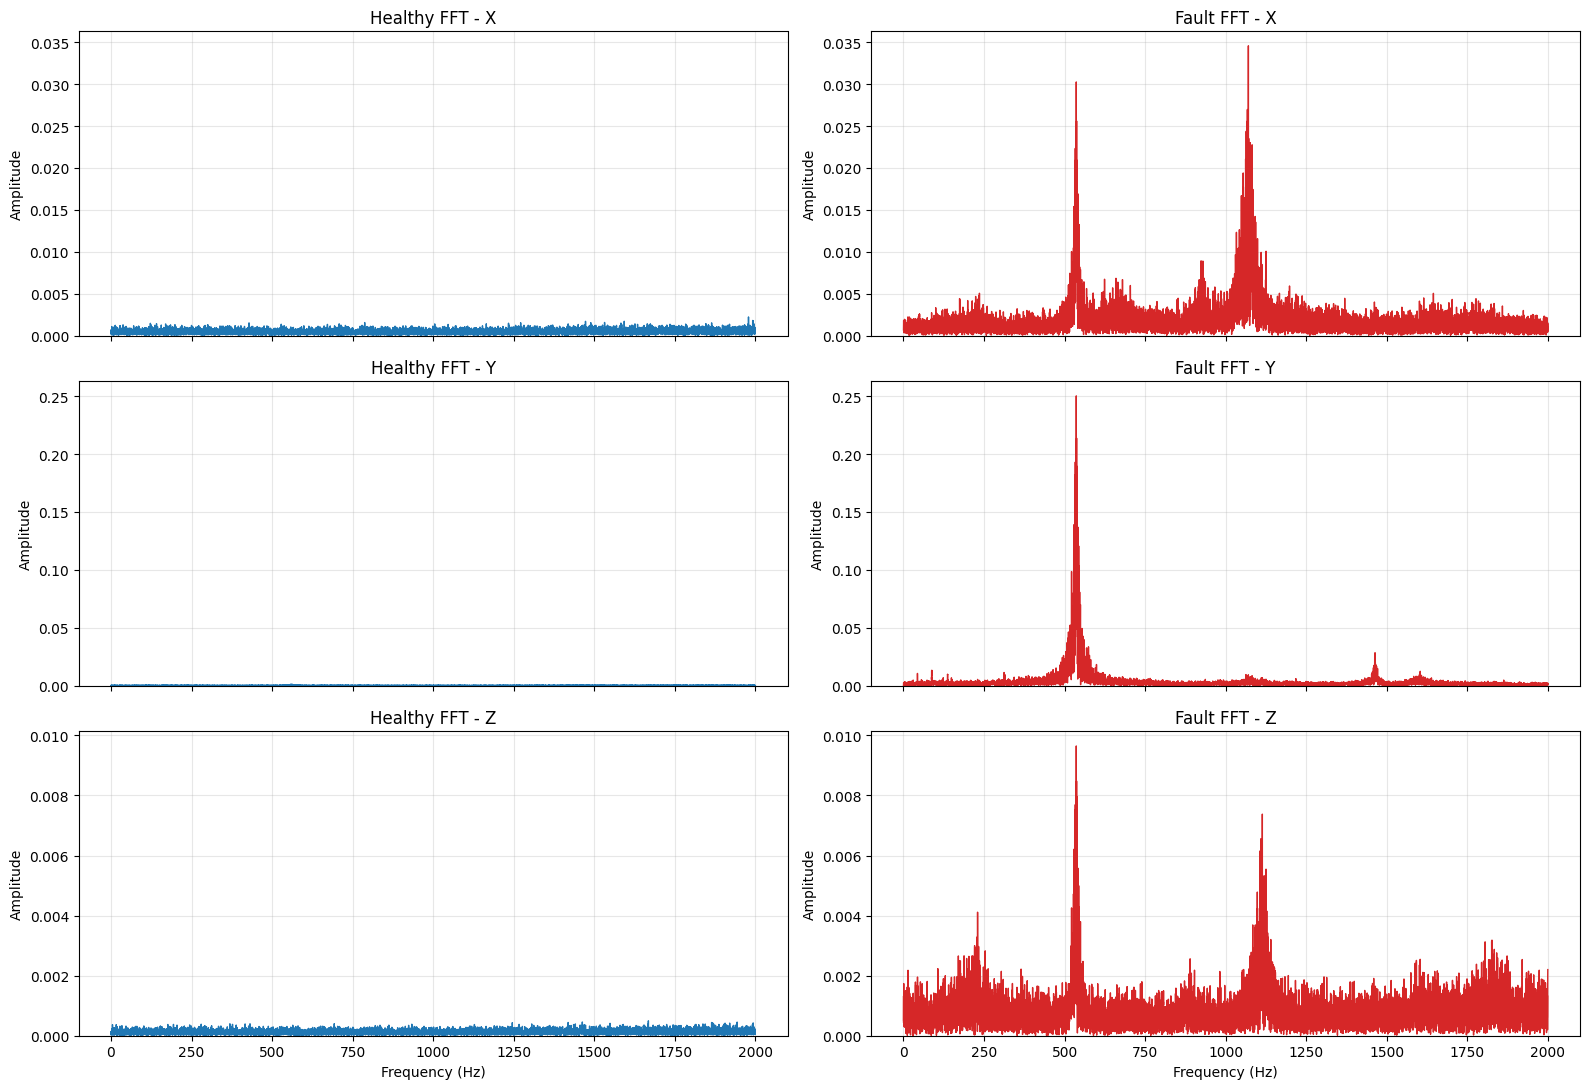

Compared length: 65536 samples


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 파일 경로
healthy_file = Path("/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/Healthy bearing data/healthy without pulley.csv")
fault_file = Path("/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-100watt-67V2Iv.csv")

fs = 10000  # 필요 시 수정

# 축 컬럼 찾기
def get_xyz_cols(df: pd.DataFrame):
    norm = {c.strip().lower().replace(" ", "").replace("-", ""): c for c in df.columns}
    x_col = norm.get("xaxis", norm.get("x"))
    y_col = norm.get("yaxis", norm.get("y"))
    z_col = norm.get("zaxis", norm.get("z"))
    if not all([x_col, y_col, z_col]):
        raise ValueError(f"x/y/z columns not found: {df.columns.tolist()}")
    return x_col, y_col, z_col

# FFT 계산
def compute_fft(sig: np.ndarray, fs: float):
    sig = sig.astype(np.float64)
    sig = sig - np.mean(sig)   # DC 제거
    n = len(sig)
    win = np.hanning(n)        # leakage 완화
    y = np.fft.rfft(sig * win)
    f = np.fft.rfftfreq(n, d=1.0 / fs)
    amp = np.abs(y) / (n / 2.0)
    return f, amp

# 데이터 로드
h_df = pd.read_csv(healthy_file)
f_df = pd.read_csv(fault_file)

hx, hy, hz = get_xyz_cols(h_df)
fx, fy, fz = get_xyz_cols(f_df)

# 동일 길이 구간 비교
max_n = 65536
n = min(len(h_df), len(f_df), max_n)

h_axes = {
    "X": pd.to_numeric(h_df[hx], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Y": pd.to_numeric(h_df[hy], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Z": pd.to_numeric(h_df[hz], errors="coerce").iloc[:n].fillna(0).to_numpy(),
}
f_axes = {
    "X": pd.to_numeric(f_df[fx], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Y": pd.to_numeric(f_df[fy], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Z": pd.to_numeric(f_df[fz], errors="coerce").iloc[:n].fillna(0).to_numpy(),
}

# 표시 주파수 범위
fmax = 2000

# 축별 FFT 계산 결과 저장
spec = {}
for axis_name in ["X", "Y", "Z"]:
    hf, ha = compute_fft(h_axes[axis_name], fs)
    ff, fa = compute_fft(f_axes[axis_name], fs)

    hm = hf <= fmax
    fm = ff <= fmax

    spec[axis_name] = {
        "hf": hf[hm], "ha": ha[hm],
        "ff": ff[fm], "fa": fa[fm],
    }

# 플롯
fig, axes = plt.subplots(3, 2, figsize=(16, 11), sharex=True)

for i, axis_name in enumerate(["X", "Y", "Z"]):
    s = spec[axis_name]

    # 같은 축의 healthy/fault y 범위를 통일
    y_max = float(max(np.max(s["ha"]), np.max(s["fa"])))
    y_min = 0.0

    # 왼쪽: Healthy
    axes[i, 0].plot(s["hf"], s["ha"], linewidth=1, color="tab:blue")
    axes[i, 0].set_title(f"Healthy FFT - {axis_name}")
    axes[i, 0].set_ylim(y_min, y_max * 1.05)
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].grid(alpha=0.3)

    # 오른쪽: Fault
    axes[i, 1].plot(s["ff"], s["fa"], linewidth=1, color="tab:red")
    axes[i, 1].set_title(f"Fault FFT - {axis_name}")
    axes[i, 1].set_ylim(y_min, y_max * 1.05)
    axes[i, 1].set_ylabel("Amplitude")
    axes[i, 1].grid(alpha=0.3)

axes[-1, 0].set_xlabel("Frequency (Hz)")
axes[-1, 1].set_xlabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

print("Compared length:", n, "samples")

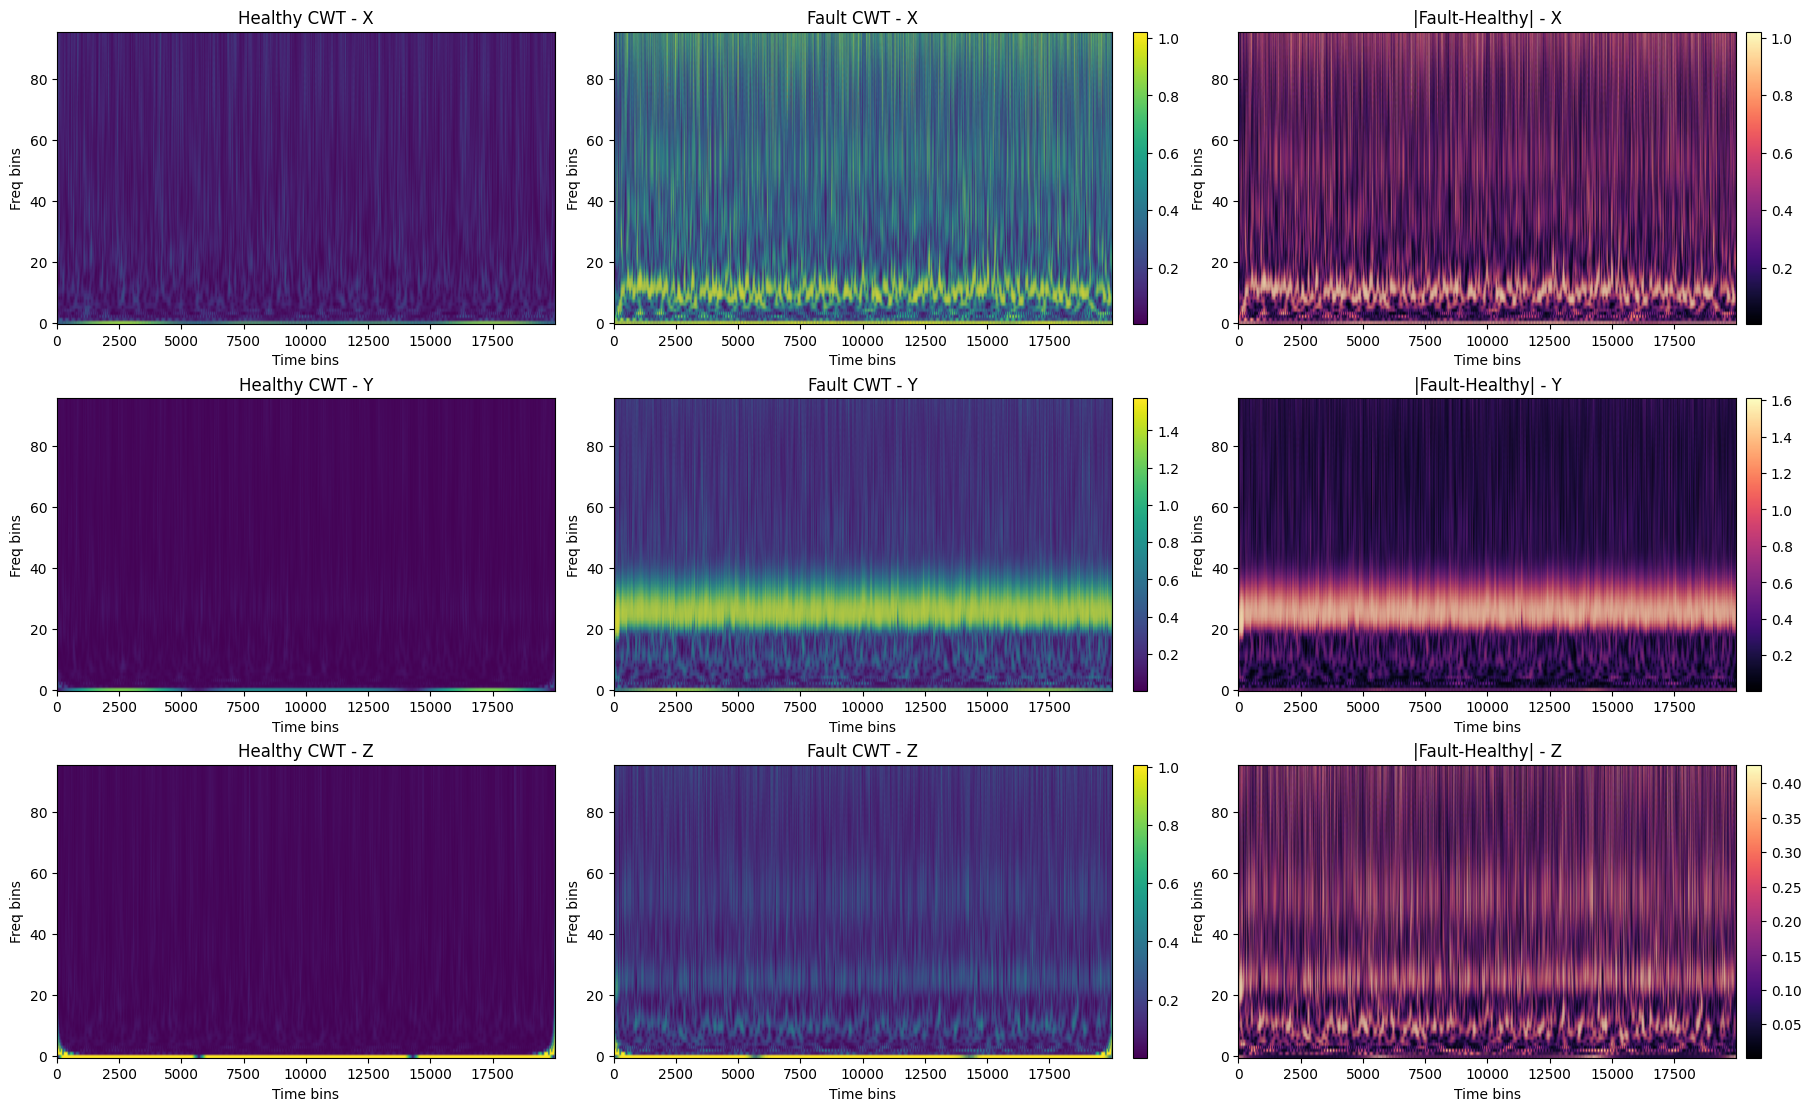

healthy: /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/Healthy bearing data/healthy without pulley.csv
fault: /content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/1.7mm-bearing-faults/1.7outer-300watt.csv
n_samples: 20000


In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# 파일 선택 (차이가 더 보이게 fault는 강한 케이스로 바꿔도 됨)
root = Path("/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2")
healthy_file = root / "Healthy bearing data" / "healthy without pulley.csv"
fault_file = root / "1.7mm-bearing-faults" / "1.7outer-300watt.csv"

fs = 10000
freq_min, freq_max, n_freqs = 1.0, 2000.0, 96
wavelet = "morl"

def get_xyz_cols(df):
    m = {c.strip().lower().replace(" ", "").replace("-", ""): c for c in df.columns}
    return m.get("xaxis", m.get("x")), m.get("yaxis", m.get("y")), m.get("zaxis", m.get("z"))

def raw_cwt_log_power(x, fs, fmin, fmax, nfreqs, wavelet):
    freqs = np.linspace(fmin, fmax, nfreqs, dtype=np.float32)
    scales = (pywt.central_frequency(wavelet) * fs) / freqs
    coeffs, _ = pywt.cwt(x, scales=scales, wavelet=wavelet, sampling_period=1.0 / fs)
    return np.log1p(np.abs(coeffs))  # per-image normalize 없음

h_df = pd.read_csv(healthy_file)
f_df = pd.read_csv(fault_file)

hx, hy, hz = get_xyz_cols(h_df)
fx, fy, fz = get_xyz_cols(f_df)

n = min(len(h_df), len(f_df), 20000)
h_axes = {
    "X": pd.to_numeric(h_df[hx], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Y": pd.to_numeric(h_df[hy], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Z": pd.to_numeric(h_df[hz], errors="coerce").iloc[:n].fillna(0).to_numpy(),
}
f_axes = {
    "X": pd.to_numeric(f_df[fx], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Y": pd.to_numeric(f_df[fy], errors="coerce").iloc[:n].fillna(0).to_numpy(),
    "Z": pd.to_numeric(f_df[fz], errors="coerce").iloc[:n].fillna(0).to_numpy(),
}

fig, axes = plt.subplots(3, 3, figsize=(18, 11), constrained_layout=True)

for i, axis_name in enumerate(["X", "Y", "Z"]):
    h_img = raw_cwt_log_power(h_axes[axis_name], fs, freq_min, freq_max, n_freqs, wavelet)
    f_img = raw_cwt_log_power(f_axes[axis_name], fs, freq_min, freq_max, n_freqs, wavelet)
    d_img = np.abs(f_img - h_img)

    # 같은 축에서 Healthy/Fault 공통 스케일
    both = np.concatenate([h_img.ravel(), f_img.ravel()])
    vmin = np.percentile(both, 1)
    vmax = np.percentile(both, 99)

    im_h = axes[i, 0].imshow(h_img, aspect="auto", origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    im_f = axes[i, 1].imshow(f_img, aspect="auto", origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)

    # 차이맵 스케일
    dvmin, dvmax = np.percentile(d_img, 1), np.percentile(d_img, 99)
    im_d = axes[i, 2].imshow(d_img, aspect="auto", origin="lower", cmap="magma", vmin=dvmin, vmax=dvmax)

    axes[i, 0].set_title(f"Healthy CWT - {axis_name}")
    axes[i, 1].set_title(f"Fault CWT - {axis_name}")
    axes[i, 2].set_title(f"|Fault-Healthy| - {axis_name}")

    for j in range(3):
        axes[i, j].set_xlabel("Time bins")
        axes[i, j].set_ylabel("Freq bins")

    # 컬러바를 바깥에 붙임
    fig.colorbar(im_f, ax=[axes[i, 0], axes[i, 1]], fraction=0.02, pad=0.02)
    fig.colorbar(im_d, ax=axes[i, 2], fraction=0.04, pad=0.02)

plt.show()

print("healthy:", healthy_file)
print("fault:", fault_file)
print("n_samples:", n)

In [11]:
# 3. fs 추정 확인

import pandas as pd
from pathlib import Path

csvs = sorted(Path("/content/AnomalyDetection/data/vib").glob("*.csv"))
if csvs:
    df = pd.read_csv(csvs[0])
    if "timestamp" in df.columns:
        ts = pd.to_datetime(df["timestamp"], errors="coerce")
        dt = ts.diff().dt.total_seconds().dropna()
        dt = dt[dt > 0]
        if len(dt) > 0:
            fs_est = 1.0 / dt.median()
            print("estimated_fs:", fs_est)
        else:
            print("could not estimate fs from timestamp")
    else:
        print("timestamp column not found")
else:
    print("csv not found (if npy only, use dataset metadata for fs)")

estimated_fs: 999999999.9999999


In [12]:
import numpy as np
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path("/content/AnomalyDetection/data/vib") / "bearing_xyz.csv")
ts = pd.to_numeric(df["timestamp"], errors="coerce")

is_index_like = ts.notna().all() and np.array_equal(ts.to_numpy(), np.arange(len(ts)))
print("timestamp_is_index_like:", is_index_like)
print("timestamp_head:", df["timestamp"].head().tolist())

timestamp_is_index_like: True
timestamp_head: [0, 1, 2, 3, 4]


In [12]:

from pathlib import Path
import re

raw_dir = Path("/content/AnomalyDetection/data/raw/vibration")

# 메타 후보 파일 확장자
patterns = ["*.txt", "*.md", "*.csv", "*.json", "*.yaml", "*.yml", "*.ini"]

candidates = []
for ptn in patterns:
    candidates.extend(raw_dir.rglob(ptn))

# fs 관련 키워드
kw = re.compile(r"(sampling|sample rate|samplerate|fs|hz|frequency)", re.IGNORECASE)

print("meta candidates:", len(candidates))
for p in candidates[:100]:
    try:
        text = p.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        continue
    if kw.search(text):
        print("\n---", p, "---")
        # 관련 줄만 출력
        lines = text.splitlines()
        matched = [ln for ln in lines if kw.search(ln)]
        for ln in matched[:20]:
            print(ln[:300])

meta candidates: 38


In [14]:
from pathlib import Path

raw_dir = Path("/content/AnomalyDetection/data/raw/vibration")
files = sorted([p for p in raw_dir.rglob("*") if p.is_file()])

print("file_count:", len(files))
for p in files[:200]:
    print(p)

file_count: 39
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-100watt-67V2Iv.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-200watt-jolm8U.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7inner-300watt-Zo8w7U.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7outer-100watt-lB5LIS.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7outer-200watt-0Pp0qm.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.7mm-bearing-faults/0.7outer-300watt-PzsIeS.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.9mm-bearing-faults/0.9inner-100watt.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.9mm-bearing-faults/0.9inner-200watt.csv
/content/AnomalyDetection/data/raw/vibration/fm6xzxnf36-2/0.9mm-bearing-faults/0.9inner-300watt.csv
/content/AnomalyDetection/data/raw/vibratio

In [13]:
# swinmae real config에 fs 반영
import yaml
from pathlib import Path

cfg_path = Path("configs/swinmae_ssl_real.yaml")
cfg = yaml.safe_load(cfg_path.read_text(encoding="utf-8"))

# TODO: 메타에서 확정값 확인 후 수정 가능
cfg["data"]["fs"] = 10000

cfg_path.write_text(yaml.safe_dump(cfg, sort_keys=False), encoding="utf-8")
print("updated data.fs =", cfg["data"]["fs"])

updated data.fs = 10000


In [14]:
from pathlib import Path
import subprocess
import sys
import shlex


def run(cmd):
    cmd = [str(x) for x in cmd]
    print('$', ' '.join(shlex.quote(x) for x in cmd))
    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,
    )

    assert proc.stdout is not None
    for line in proc.stdout:
        print(line, end='')

    code = proc.wait()
    if code != 0:
        raise RuntimeError(f"Command failed ({code}): {' '.join(cmd)}")


req = Path('requirements.txt')
if not req.exists():
    raise FileNotFoundError(
        f"requirements.txt not found in cwd={Path.cwd()}. Run bootstrap cell first or fix repo path."
    )

run([sys.executable, '-m', 'pip', 'install', '-U', 'pip'])
run([sys.executable, '-m', 'pip', 'install', '-r', str(req)])


$ /usr/bin/python3 -m pip install -U pip
$ /usr/bin/python3 -m pip install -r requirements.txt


In [15]:
import torch

print('torch:', torch.__version__)
print('cuda_available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('cuda_device_count:', torch.cuda.device_count())
    print('cuda_device_0:', torch.cuda.get_device_name(0))


torch: 2.10.0+cu128
cuda_available: True
cuda_device_count: 1
cuda_device_0: Tesla T4


In [16]:
# 1. swinmae_ssl_real.yaml 수정 코드는 코드 셀에 실행

import yaml
from pathlib import Path

cfg_path = Path("/content/AnomalyDetection/configs/swinmae_ssl_real.yaml")
cfg = yaml.safe_load(cfg_path.read_text(encoding="utf-8"))

cfg["training"]["epochs"] = 10
cfg["training"]["lr"] = 1e-4
cfg["device"]["amp"] = False
cfg["model"]["mask_ratio"] = 0.3

cfg_path.write_text(yaml.safe_dump(cfg, sort_keys=False), encoding="utf-8")
print("updated:", cfg_path)

updated: /content/AnomalyDetection/configs/swinmae_ssl_real.yaml


In [17]:
# 2. 로그 폴더 삭제 + 재학습은 다음 코드 셀에 실행 (! 붙이기)

!rm -rf /content/AnomalyDetection/runs/swinmae_ssl

In [18]:
import os
import shlex
import subprocess
import sys
from pathlib import Path

def run_stream(cmd):
    cmd = [str(x) for x in cmd]
    print('$', ' '.join(shlex.quote(x) for x in cmd))

    env = os.environ.copy()
    env["PYTHONUNBUFFERED"] = "1"

    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,
        env=env,
    )

    assert proc.stdout is not None
    for line in proc.stdout:
        print(line, end='')

    code = proc.wait()
    if code != 0:
        raise RuntimeError(f"Training failed with exit code {code}")

cfg = Path("configs/swinmae_ssl_real.yaml")
if not cfg.exists():
    print("[warn] real config not found, fallback to synthetic config")
    cfg = Path("configs/swinmae_ssl.yaml")

run_stream([sys.executable, "-u", "-m", "trainers.train_swinmae_ssl", "--config", str(cfg)])

$ /usr/bin/python3 -u -m trainers.train_swinmae_ssl --config configs/swinmae_ssl_real.yaml
2026-02-23 04:09:07.999111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771819748.020123    2671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771819748.027253    2671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771819748.045570    2671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771819748.045595    2671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than on

In [19]:
from pathlib import Path

checkpoint_path = Path('checkpoints/swinmae_ssl.pt')
print('checkpoint_exists:', checkpoint_path.exists(), checkpoint_path)
assert checkpoint_path.exists(), f'Missing checkpoint: {checkpoint_path}'
print('checkpoint_size_bytes:', checkpoint_path.stat().st_size)


checkpoint_exists: True checkpoints/swinmae_ssl.pt
checkpoint_size_bytes: 355239007


In [20]:
# 1. 산출물 확인
#     목적: 학습 결과가 실제 파일로 남았는지 확인.

from pathlib import Path
for p in [
    "checkpoints/patchtst_ssl.pt",
    "checkpoints/swinmae_ssl.pt",
    "configs/patchtst_ssl_real.yaml",
    "configs/swinmae_ssl_real.yaml",
]:
    q = Path(p)
    print(p, q.exists(), q.stat().st_size if q.exists() else 0)

checkpoints/patchtst_ssl.pt True 4921417
checkpoints/swinmae_ssl.pt True 355239007
configs/patchtst_ssl_real.yaml True 909
configs/swinmae_ssl_real.yaml True 1154


In [ ]:
# # DEBUG: checkpoint config sanity check
# import torch
# ckpt = torch.load("checkpoints/patchtst_ssl.pt", map_location="cpu")
# cfg = ckpt.get("config", {})
# print("patch source:", cfg.get("data", {}).get("source"))
# print("patch path  :", cfg.get("data", {}).get("path"))

patch source: synthetic
patch path  : data/fdc/*.csv


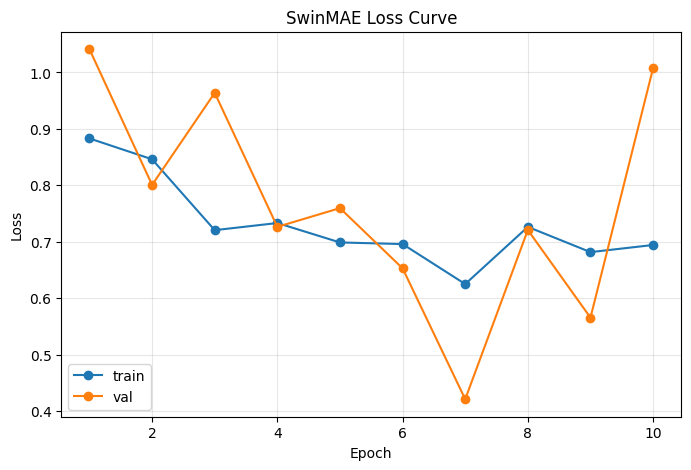

In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

run_dir = Path("/content/AnomalyDetection/runs/swinmae_ssl")
ea = event_accumulator.EventAccumulator(str(run_dir))
ea.Reload()

train = ea.Scalars("loss/train")
val = ea.Scalars("loss/val")

x1 = [s.step for s in train]; y1 = [s.value for s in train]
x2 = [s.step for s in val];   y2 = [s.value for s in val]

plt.figure(figsize=(8,5))
plt.plot(x1, y1, marker="o", label="train")
plt.plot(x2, y2, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SwinMAE Loss Curve")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [22]:
import subprocess, sys
from pathlib import Path
import shutil, time

# 1) PatchTST smoke
subprocess.run([
    sys.executable, "-m", "inference.run_scoring_example",
    "--stream", "patchtst",
    "--checkpoint", "checkpoints/patchtst_ssl.pt",
    "--config", "configs/patchtst_ssl_real.yaml"
], check=True)

# 2) SwinMAE smoke
subprocess.run([
    sys.executable, "-m", "inference.run_scoring_example",
    "--stream", "swinmae",
    "--checkpoint", "checkpoints/swinmae_ssl.pt",
    "--config", "configs/swinmae_ssl_real.yaml"
], check=True)

# 3) save bundle (both)
save_dir = Path(f"/content/run_bundle_{time.strftime('%Y%m%d_%H%M%S')}")
save_dir.mkdir(parents=True, exist_ok=True)
for p in [
    "checkpoints/patchtst_ssl.pt",
    "checkpoints/swinmae_ssl.pt",
    "configs/patchtst_ssl_real.yaml",
    "configs/swinmae_ssl_real.yaml",
]:
    q = Path(p)
    if q.exists():
        shutil.copy2(q, save_dir / q.name)

print("saved_to:", save_dir)
print([x.name for x in save_dir.iterdir()])

saved_to: /content/run_bundle_20260223_041539
['swinmae_ssl_real.yaml', 'patchtst_ssl_real.yaml', 'patchtst_ssl.pt', 'swinmae_ssl.pt']


In [23]:
# 백업 번들 만들기(Colab 셀):

%cd /content/AnomalyDetection
!mkdir -p artifacts/bundles
!BUNDLE=/content/run_bundle_$(date +%Y%m%d_%H%M%S).tar.gz && \
tar -czf $BUNDLE \
checkpoints \
configs/patchtst_ssl_real.yaml \
configs/swinmae_ssl_real.yaml \
artifacts/scaler_fdc.json \
artifacts/dqvl \
runs/patchtst_ssl \
runs/swinmae_ssl && \
cp $BUNDLE artifacts/bundles/ && \
echo $BUNDLE

# # 로컬 다운로드(선택):

# from glob import glob
# from google.colab import files
# latest = sorted(glob("/content/run_bundle_*.tar.gz"))[-1]
# files.download(latest)

/content
/content/run_bundle_20260223_041548.tar.gz


In [24]:
# 체크리스트
%cd /content/AnomalyDetection
!python -m pipelines.validate_training_outputs --repo-root /content/AnomalyDetection

/content
Training Output Validation Checklist
1. [v] PASS - Check trained checkpoints
   detail: patchtst:patchtst_ssl.pt(4.7MB), swinmae:swinmae_ssl.pt(338.8MB)

2. [v] PASS - Check PatchTST scaler artifact
   detail: scaler_fdc.json keys=['center', 'eps', 'method', 'scale']

3. [v] PASS - Check TensorBoard logs
   detail: patchtst:1 event file(s), swinmae:1 event file(s)

4. [v] PASS - Check final training configs
   detail: patchtst:source=csv, lr=0.0001, epochs=10, mask_ratio=0.4, amp=False, swinmae:source=csv, lr=0.0001, epochs=10, mask_ratio=0.3, amp=False

5. [v] PASS - Check backup bundle
   detail: run_bundle_20260223_041548.tar.gz(316.7MB)

6. [v] PASS - Run scoring smoke test for both streams
   detail: patchtst:ok, swinmae:ok

7. [v] PASS - Check split policy documentation
   detail: /content/AnomalyDetection/docs/calibration_split_policy.md contains split criteria.

Summary: 7/7 passed, 0 failed


In [ ]:
# 최신 내용으로 git pull
%cd /content/AnomalyDetection
!git pull
!ls -la pipelines

/content
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17 (delta 9), reused 17 (delta 9), pack-reused 0 (from 0)
Unpacking objects: 100% (17/17), 80.94 KiB | 310.00 KiB/s, done.
From https://github.com/kh87joo2/AnomalyDetection
   1690511..e101df2  main       -> origin/main
Updating 1690511..e101df2
Fast-forward
 README.md                              |   14 +
 docs/calibration_split_policy.md       |   28 +
 docs/runbook.md                        |   11 +
 notebooks/colab_patchtst_ssl.ipynb     | 1330 ++++++++++++++++++--------------
 notebooks/colab_swinmae_ssl.ipynb      |  363 +++++++--
 pipelines/__init__.py                  |    2 +
 pipelines/validate_training_outputs.py |  419 ++++++++++
 requirements.txt                       |    1 +
 trainers/train_patchtst_ssl.py         |   20 +-
 trainers/train_swinmae_ssl.py          |   20 +-
 trainers/utils.py                      |   49

In [26]:
%cd /content/AnomalyDetection

/content


In [27]:
!git branch -vv
!git log --oneline -8

* main 65bf87a [origin/main] chore(notebooks): update swinmae colab workflow state
65bf87a (HEAD -> main, origin/main, origin/HEAD) chore(notebooks): update swinmae colab workflow state
e101df2 feat(pipeline): add post-training validation checklist and loss artifact export
1690511 feat(phase1.5): stabilize patchtst real-data training and finalize colab artifacts [2026-02-21]
1900eb4 docs(log): add 2026-02-21 execution summary and next steps
405affb chore(notebooks): refine colab execution flow [2026-02-21]
eac95da docs(log): add 2026-02-20 progress and restart checklist
8ee3af8 feat(phase1.5): real-data pipeline + colab data flow [2026-02-20]
6310905 docs(archive): preserve phase1 legacy PRD/TRD/Todo


In [30]:
%cd /content/AnomalyDetection
!git fetch origin
!git checkout main
!git pull --ff-only
!git log --oneline -8
!ls -la pipelines/export_training_dashboard_state.py pipelines/validate_training_outputs.py

/content
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 93 (delta 34), reused 93 (delta 34), pack-reused 0 (from 0)
Unpacking objects: 100% (93/93), 53.48 KiB | 265.00 KiB/s, done.
From https://github.com/kh87joo2/AnomalyDetection
   65bf87a..ee291c9  main       -> origin/main
Already on 'main'
Your branch is behind 'origin/main' by 8 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)
Updating 65bf87a..ee291c9
Fast-forward
 .gitignore                                         |    1 +
 .ralph-loop/README.md                              |    4 +
 .ralph-loop/next-task.py                           |   46 +
 .ralph-loop/setup.py                               | 1008 ++++++++++++++++++++
 AGENTS.md                                          |   17 +
 DashboardSample/dashboard/FINAL_SUMMARY.md         |  116 +++
 .../dashboard/FINAL_SUMMARY.md:Zone.Identifier   

In [25]:

%cd /content/AnomalyDetection
!python -m pipelines.export_training_dashboard_state \
--repo-root /content/AnomalyDetection \
--out /content/AnomalyDetection/training_dashboard/data/dashboard-state.json \
--run-id colab-t02-check \
--run-smoke

/content
exported: /content/AnomalyDetection/training_dashboard/data/dashboard-state.json
checklist: 7/7 passed


In [26]:
import json
p="/content/AnomalyDetection/training_dashboard/data/dashboard-state.json"
d=json.load(open(p,"r",encoding="utf-8"))
print(sorted(d.keys()))
print("checklist:", sum(1 for x in d["checklist"] if x["passed"]), "/", len(d["checklist"]))
for x in d["checklist"]:
    print(f"{x['index']}. {'PASS' if x['passed'] else 'FAIL'} - {x['title']}")

['artifacts', 'checklist', 'meta', 'metrics', 'nodes']
checklist: 7 / 7
1. PASS - Check trained checkpoints
2. PASS - Check PatchTST scaler artifact
3. PASS - Check TensorBoard logs
4. PASS - Check final training configs
5. PASS - Check backup bundle
6. PASS - Run scoring smoke test for both streams
7. PASS - Check split policy documentation


In [47]:
# 1. 최신 코드 반영
%cd /content/AnomalyDetection
!git pull

/content
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 37 (delta 21), reused 37 (delta 21), pack-reused 0 (from 0)
Unpacking objects: 100% (37/37), 20.51 KiB | 121.00 KiB/s, done.
From https://github.com/kh87joo2/AnomalyDetection
   ee291c9..652ef68  main       -> origin/main
Updating ee291c9..652ef68
Fast-forward
 IMPLEMENTATION_PLAN.md                        |   4 +-
 notebooks/colab_swinmae_ssl.ipynb             | 452 ++++++++++++++++++++------
 pipelines/export_training_dashboard_state.py  | 138 +++++++-
 tests/pipelines/test_dashboard_run_history.py | 169 ++++++++++
 training_dashboard/css/main.css               | 280 ++++++++++++++++
 training_dashboard/css/nodes.css              |  19 ++
 training_dashboard/index.html                 |  83 ++++-
 training_dashboard/js/app.js                  | 339 ++++++++++++++++++-
 training_dashboard/js/panels.js               | 193 +++++++++

In [27]:
# 2. run 두 개 생성
!python -m pipelines.export_training_dashboard_state --repo-root . --out training_dashboard/data/dashboard-state.json --run-id colab_run_a --persist-run-history
!python -m pipelines.export_training_dashboard_state --repo-root . --out training_dashboard/data/dashboard-state.json --run-id colab_run_b --persist-run-history

exported: training_dashboard/data/dashboard-state.json
checklist: 7/7 passed
run_snapshot: training_dashboard/data/runs/colab_run_a.json
run_index: training_dashboard/data/runs/index.json
exported: training_dashboard/data/dashboard-state.json
checklist: 7/7 passed
run_snapshot: training_dashboard/data/runs/colab_run_b.json
run_index: training_dashboard/data/runs/index.json


In [28]:
# 3. 파일 확인
!ls -la training_dashboard/data/runs
!python -m json.tool training_dashboard/data/runs/index.json

total 36
drwxr-xr-x 2 root root 4096 Feb 23 04:18 .
drwxr-xr-x 3 root root 4096 Feb 23 04:18 ..
-rw-r--r-- 1 root root 9413 Feb 23 04:18 colab_run_a.json
-rw-r--r-- 1 root root 9413 Feb 23 04:18 colab_run_b.json
-rw-r--r-- 1 root root  681 Feb 23 04:18 index.json
{
    "generated_at": "2026-02-23T04:18:08+00:00",
    "runs": [
        {
            "run_id": "colab_run_b",
            "file": "colab_run_b.json",
            "timestamp": "2026-02-23T04:18:08+00:00",
            "checklist": {
                "passed": 7,
                "total": 7
            },
            "final_val_loss": {
                "patchtst": 21.153209686279297,
                "swinmae": 1.0077625513076782
            }
        },
        {
            "run_id": "colab_run_a",
            "file": "colab_run_a.json",
            "timestamp": "2026-02-23T04:18:08+00:00",
            "checklist": {
                "passed": 7,
                "total": 7
            },
            "final_val_loss": {
          

In [39]:
# 4. 서버는 반드시 백그라운드 + 새 포트

!pkill -9 -f "http.server 8877" || true
!nohup python -m http.server 8899 --directory /content/AnomalyDetection/training_dashboard > /tmp/dashboard.log 2>&1 &
!sleep 1
!curl -I --max-time 3 http://127.0.0.1:8899 || true

^C
HTTP/1.0 200 OK
Server: SimpleHTTP/0.6 Python/3.12.12
Date: Mon, 23 Feb 2026 04:27:02 GMT
Content-type: text/html
Content-Length: 4253
Last-Modified: Mon, 23 Feb 2026 04:00:41 GMT



In [42]:
# 서버 확인

!ps -ef | grep "http.server 8899" | grep -v grep || true
!curl -I --max-time 5 http://127.0.0.1:8899 || true
!tail -n 30 /tmp/dashboard.log

root        6076       1  0 04:22 ?        00:00:00 python3 -m http.server 8899 --directory /content/AnomalyDetection/training_dashboard
HTTP/1.0 200 OK
Server: SimpleHTTP/0.6 Python/3.12.12
Date: Mon, 23 Feb 2026 04:28:12 GMT
Content-type: text/html
Content-Length: 4253
Last-Modified: Mon, 23 Feb 2026 04:00:41 GMT

Traceback (most recent call last):
  File "<frozen runpy>", l127.0.0.1 - - [23/Feb/2026 04:27:02] "HEAD / HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2026 04:27:56] "HEAD / HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2026 04:28:12] "HEAD / HTTP/1.1" 200 -
2/http/server.py", line 1261, in test
    with ServerClass(addr, HandlerClass) as httpd:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socketserver.py", line 457, in __init__
    self.server_bind()
  File "/usr/lib/python3.12/http/server.py", line 1308, in server_bind
    return super().server_bind()
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/http/server.py", line 136, in server_bind
    socket

In [37]:
import requests
from google.colab._message import blocking_request

resp = blocking_request('request_browser', {
    'url': 'http://127.0.0.1:8899',
    'new_tab': True
}, timeout_sec=10)
print(resp)

None
